## Ext. Data Figure 9: Model Simulations Recapitulate Characteristics of Real Data

This notebook recreates the figure panels included in Extended Data Figure 9 of [Bolkan, Stone et al 2021](https://www.biorxiv.org/content/10.1101/2021.07.23.453573v1). 

The general premise of this notebook/figure, in the context of the paper, is to show that fitting the model to simulated datasets produces similar results, in terms of the transition probabilities and state characteristics, of the real data. This serves as a sanity check to ensure that the model can indeed capture fundamental properties of the real data in its simulations. <b>Note:</b> The results for the simulations in the notebook might not look <i>exactly</i> like they do in the paper because there is some stochasticity inherent in generating the simulated data. A way to get around this in your own analyses is to set a seed (e.g. <code>np.random.seed(1234)</code>) that will allow you to replicate the exact same simulated dataset if you rerun this code in the future.

### Simulate data
#### Import the required code packages and modules

In [17]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import pickle
from glmhmm import glm, glm_hmm
from glmhmm.utils import find_best_fit, permute_states

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load the model objects from fitting the GLM-HMM to the real data

In [2]:
GLMHMM_d2 = pickle.load(open('fit models/GLMHMM_d2.pickle','rb'))
GLMHMM_d1 = pickle.load(open('fit models/GLMHMM_d1.pickle','rb'))

#### Load the real data

In [65]:
# load the data for the indirect pathway cohort
x_d2 = np.load('data/indirect_x.npy') # z-scored design matrix
y_d2 = np.load('data/indirect_y.npy') # vector of right and left choices for each trial
sessions_d2 = np.load('data/indirect_sessions.npy') # vector of session start and stop indices
mouseIDs_d2 = np.load('data/indirect_mouseIDs.npy') # vector of mouse IDs for each trial
trialTypes_d2 = np.load('data/indirect_trialTypes.npy') # vector of trial types (which side rewarded) for each trial

# load the data for the direct pathway cohort
x_d1 = np.load('data/direct_x.npy') # z-scored design matrix
y_d1 = np.load('data/direct_y.npy') # vector of right and left choices for each trial
sessions_d1 = np.load('data/direct_sessions.npy') # vector of session start and stop indices
mouseIDs_d1 = np.load('data/direct_mouseIDs.npy') # vector of mouse IDs for each trial
trialTypes_d1 = np.load('data/direct_trialTypes.npy') # vector of trial types (which side rewarded) for each trial

# set plot color preferences
colors = np.array([[39,110,167],[237,177,32],[233,0.0001,111]])/255

#### Simulate five datasets

In [4]:
num_sims = 5
simulated_x_d2 = np.zeros((num_sims,x_d2.shape[0],x_d2.shape[1]))
simulated_y_d2 = np.zeros((num_sims,y_d2.shape[0]))
simulated_x_d1 = np.zeros((num_sims,x_d1.shape[0],x_d1.shape[1]))
simulated_y_d1 = np.zeros((num_sims,y_d1.shape[0]))
for i in range(num_sims):
    ## indirect pathway cohort --------------------------------------------------------
    simulated_x_d2[i], simulated_y_d2[i], _ = GLMHMM_d2.generate_data_from_fit(GLMHMM_d2.w,GLMHMM_d2.A,x_d2,
                                                                             obs_ix=[3,9,10],replace=True,
                                                                             sessions=sessions_d2,
                                                                             outcomes=trialTypes_d2)
    ## direct pathway cohort --------------------------------------------------------
    simulated_x_d1[i], simulated_y_d1[i], _ = GLMHMM_d1.generate_data_from_fit(GLMHMM_d1.w,GLMHMM_d1.A,x_d1,
                                                                             obs_ix=[3,9,10],replace=True,
                                                                             sessions=sessions_d1,
                                                                             outcomes=trialTypes_d1)

### Fit GLM-HMMs to the simulated data
#### Set the hyperparameters

In [5]:
N_d2 = x_d2.shape[0] # number of data/time points for the indirect pathway cohort
N_d1 = x_d1.shape[0]
K = 3 # number of latent states
C = 2 # number of observation classes
D = x_d2.shape[1] # number of GLM inputs (regressors)

#### Fit the models
This will take about 20 hours to run in this notebook (5 simulated datasets x 2 cohorts x 2 hours per fit). Best to parallelize this and run each cohort and fit separately if you don't want to wait so long!

In [7]:
inits = 20 # set the number of initializations
maxiter = 250 # maximum number of iterations of EM to allow for each fit
tol = 1e-3

# store model objects for each simulated dataset
best_GLMHMMs_d2 = np.zeros((num_sims), dtype=object)
best_GLMHMMs_d1 = np.zeros((num_sims), dtype=object)

for j in range(num_sims):

    # store values for each initialization
    lls_all_d2 = np.zeros((inits,250))
    GLMHMMs_d2 = np.zeros((inits),dtype=object)
    lls_all_d1 = np.zeros((inits,250))
    GLMHMMs_d1 = np.zeros((inits),dtype=object)

    # fit the model for each initialization
    for i in range(inits):
        ## indirect pathway cohort --------------------------------------------------------
        GLMHMMs_d2[i] = glm_hmm.GLMHMM(N_d2,D,C,K,observations="bernoulli",gaussianPrior=1)
        A_init,w_init,_ = GLMHMMs_d2[i].generate_params(weights=['GLM',-0.2,1.2,simulated_x_d2[j],simulated_y_d2[j],1])
        lls_all_d2[i,:],_,_,_ = GLMHMMs_d2[i].fit(simulated_y_d2[j],simulated_x_d2[j],A_init,w_init,
                                                  maxiter=maxiter,tol=tol,sess=sessions_d2)

        ## direct pathway cohort ----------------------------------------------------------
        GLMHMMs_d1[i] = glm_hmm.GLMHMM(N_d1,D,C,K,observations="bernoulli",gaussianPrior=1)
        A_init,w_init,_ = GLMHMMs_d1[i].generate_params(weights=['GLM',-0.2,1.2,simulated_x_d1[j],simulated_y_d1[j],1])
        lls_all_d1[i,:],_,_,_ = GLMHMMs_d1[i].fit(simulated_y_d1[j],simulated_x_d1[j],A_init,w_init,
                                                  maxiter=maxiter,tol=tol,sess=sessions_d1)

    # find the initialization that led to the best fit
    bestix_d2 = find_best_fit(lls_all_d2)
    best_GLMHMMs_d2[j] = GLMHMMs_d2[bestix_d2]
    bestix_d1 = find_best_fit(lls_all_d1)
    best_GLMHMMs_d1[j] = GLMHMMs_d1[bestix_d1]    
    
# save results in case we want to use them again later
pickle.dump(best_GLMHMMs_d2, open('fit models/simulated_GLMHMMs_d2.pickle', 'wb'))
pickle.dump(best_GLMHMMs_d1, open('fit models/simulated_GLMHMMs_d1.pickle', 'wb'))

#### Permute the order of the parameters

In [89]:
##### true parameters -----------------------------------------------
# get order of permuted states
_,order_d2 = permute_states(GLMHMM_d2.w[:,:,1],method='weight value',param='weights',ix=1)
_,order_d1 = permute_states(GLMHMM_d1.w[:,:,1],method='weight value',param='weights',ix=1)

# permute order of transition probabilities
A_d2, _ = permute_states(GLMHMM_d2.A,method='order',order=order_d2)
A_d1, _ = permute_states(GLMHMM_d1.A,method='order',order=order_d1)

# permute order of state probabilities
pstate_d2,_ = permute_states(GLMHMM_d2.pStates,method='order',param='pstates',order=order_d2)
pstate_d1,_ = permute_states(GLMHMM_d1.pStates,method='order',param='pstates',order=order_d1)

# permute the order of the states
state_d2,_ = permute_states(GLMHMM_d2.states,method='order',param='states',order=order_d2)
state_d1,_ = permute_states(GLMHMM_d1.states,method='order',param='states',order=order_d1)

##### simulated parameters -----------------------------------------------
A_sim_d2 = np.zeros((num_sims,GLMHMM_d2.k,GLMHMM_d2.k))
A_sim_d1 = np.zeros((num_sims,GLMHMM_d1.k,GLMHMM_d1.k))
pstate_sim_d2 = np.zeros((num_sims,GLMHMM_d2.n,GLMHMM_d2.k))
pstate_sim_d1 = np.zeros((num_sims,GLMHMM_d1.n,GLMHMM_d1.k))
state_sim_d2 = np.zeros((num_sims,GLMHMM_d2.n))
state_sim_d1 = np.zeros((num_sims,GLMHMM_d1.n))
for i in range(num_sims):
    # get order of permuted states
    _,order_d2 = permute_states(best_GLMHMMs_d2[i].w[:,:,1],method='weight value',param='weights',ix=1)
    _,order_d1 = permute_states(best_GLMHMMs_d1[i].w[:,:,1],method='weight value',param='weights',ix=1)

    # permute order of transition probabilities
    A_sim_d2[i], _ = permute_states(best_GLMHMMs_d2[i].A,method='order',order=order_d2)
    A_sim_d1[i], _ = permute_states(best_GLMHMMs_d1[i].A,method='order',order=order_d1)
    
    # permute order of state probabilities
    pstate_sim_d2[i],_ = permute_states(best_GLMHMMs_d2[i].pStates,method='order',param='pstates',order=order_d2)
    pstate_sim_d1[i],_ = permute_states(best_GLMHMMs_d1[i].pStates,method='order',param='pstates',order=order_d1)
    
    # permute the order of the states
    state_sim_d2[i],_ = permute_states(best_GLMHMMs_d2[i].states,method='order',param='states',order=order_d2)
    state_sim_d1[i],_ = permute_states(best_GLMHMMs_d1[i].states,method='order',param='states',order=order_d1)

### Ext. Data Figure 9a/b: Compare the Transition Probabilities

(0.0, 0.015)

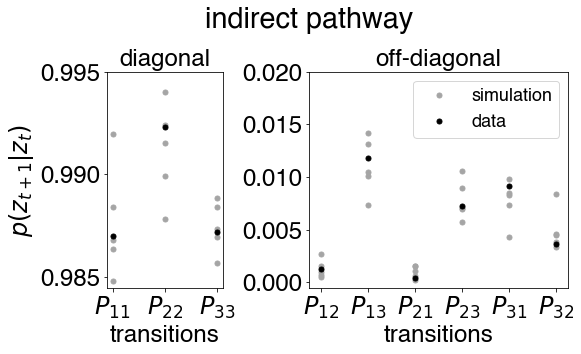

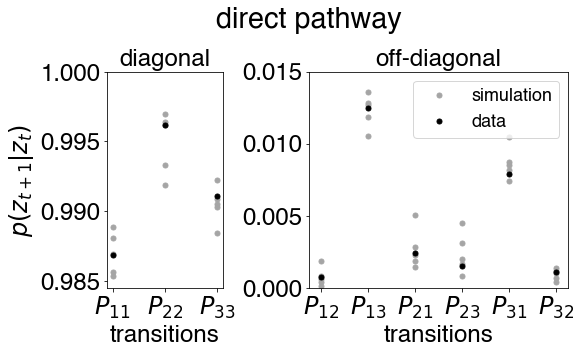

In [60]:
from glmhmm.visualize import plot_simulated_vs_true_transitions

fig = plt.figure(figsize=(8,3))
# format axes (start left, start bottom, width, height)
axes = [plt.axes([0, 0, 0.20, 1]),plt.axes([.35, 0, .45, 1])]

plt.suptitle('indirect pathway',x = 0.35, y = 1.3, fontweight='bold')
plot_simulated_vs_true_transitions(A_d2,A_sim_d2,axes[0],diag=True)
plot_simulated_vs_true_transitions(A_d2,A_sim_d2,axes[1],diag=False)
axes[1].set_ylabel('')

fig = plt.figure(figsize=(8,3))
# format axes (start left, start bottom, width, height)
axes = [plt.axes([0, 0, 0.20, 1]),plt.axes([.35, 0, .45, 1])]

plt.suptitle('direct pathway',x = 0.35, y = 1.3, fontweight='bold')
plot_simulated_vs_true_transitions(A_d1,A_sim_d1,axes[0],diag=True)
plot_simulated_vs_true_transitions(A_d1,A_sim_d1,axes[1],diag=False)
axes[0].set_yticks(np.arange(0.985,1.001,0.005))
axes[1].set_ylabel('')
axes[1].set_ylim([0,0.015])

### Ext. Data Figure 9c/d: Compare the Posterior State Probabilities

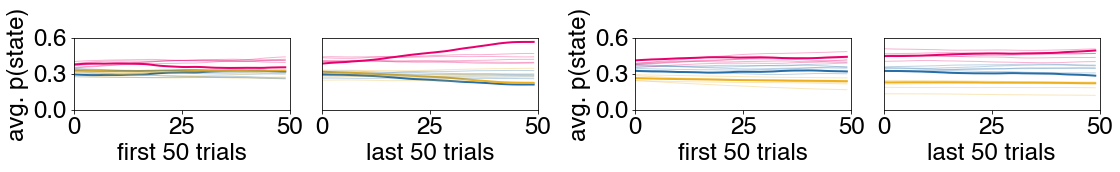

In [87]:
from glmhmm.visualize import plot_average_state_probabilities

fig = plt.figure(figsize=(15,1))
# format axes (start left, start bottom, width, height)
axes = [plt.axes([0, 0, 0.20, 1]),plt.axes([.23, 0, .20, 1]),\
        plt.axes([0.52, 0, 0.20, 1]),plt.axes([0.75, 0, 0.20, 1])]

# plot real data
plot_average_state_probabilities(pstate_d2,sessions_d2,colors,axes[0:2],linewidth=2)
plot_average_state_probabilities(pstate_d1,sessions_d1,colors,axes[2:4],linewidth=2)

# add simulations
for i in range(num_sims):
    plot_average_state_probabilities(pstate_sim_d2[i],sessions_d2,colors,axes[0:2],alpha=0.3,linewidth=1)
    plot_average_state_probabilities(pstate_sim_d1[i],sessions_d1,colors,axes[2:4],alpha=0.3,linewidth=1)

### Ext. Data Figure 9e: Compare Average Dwell Time (Indirect Pathway, without terminal run)

Text(0.2, 1.6, 'average dwell time \n (without terminal run)')

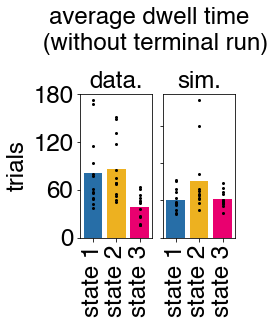

In [122]:
from glmhmm.visualize import plot_average_dwell_time

fig = plt.figure(figsize=(5,2))
# format axes (start left, start bottom, width, height)
axes = [plt.axes([0, 0, 0.20, 1]),plt.axes([.23, 0, .20, 1])]

plot_average_dwell_time(state_d2,sessions_d2,mouseIDs_d2,colors,axes[0])
plot_average_dwell_time(state_sim_d2[0],sessions_d2,mouseIDs_d2,colors,axes[1])
axes[0].set_title('data.',fontsize=24)
axes[1].set_title('sim.',fontsize=24)
axes[1].set_yticklabels('')
axes[1].set_ylabel('')
plt.suptitle('average dwell time \n (without terminal run)',fontsize=24, x=0.2, y=1.6)

### Ext. Data Figure 9f: Compare Average Dwell Time (Indirect Pathway, with terminal run)

Text(0.2, 1.6, 'average dwell time \n (with terminal run)')

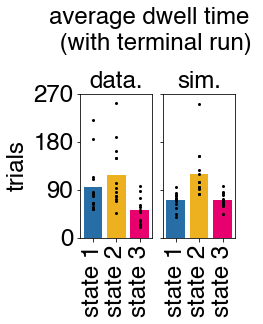

In [123]:
fig = plt.figure(figsize=(5,2))
# format axes (start left, start bottom, width, height)
axes = [plt.axes([0, 0, 0.20, 1]),plt.axes([.23, 0, .20, 1])]

plot_average_dwell_time(state_d2,sessions_d2,mouseIDs_d2,colors,axes[0],terminal_run=True)
plot_average_dwell_time(state_sim_d2[0],sessions_d2,mouseIDs_d2,colors,axes[1],terminal_run=True)
axes[0].set_title('data.',fontsize=24)
axes[0].set_yticks(np.arange(0,271,90))
axes[0].set_yticklabels(np.arange(0,271,90))
axes[1].set_title('sim.',fontsize=24)
axes[1].set_yticks(np.arange(0,271,90))
axes[1].set_yticklabels('')
axes[1].set_ylabel('')
plt.suptitle('average dwell time \n (with terminal run)',fontsize=24, x=0.2, y=1.6)

### Ext. Data Figure 9g: Compare Average Dwell Time (Direct Pathway, without terminal run)

Text(0.2, 1.6, 'average dwell time \n (without terminal run)')

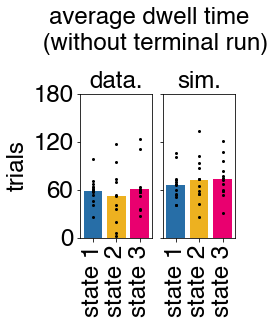

In [131]:
fig = plt.figure(figsize=(5,2))
# format axes (start left, start bottom, width, height)
axes = [plt.axes([0, 0, 0.20, 1]),plt.axes([.23, 0, .20, 1])]

plot_average_dwell_time(state_d1,sessions_d1,mouseIDs_d1,colors,axes[0])
plot_average_dwell_time(state_sim_d1[3],sessions_d1,mouseIDs_d1,colors,axes[1])
axes[0].set_title('data.',fontsize=24)
axes[1].set_title('sim.',fontsize=24)
axes[1].set_yticklabels('')
axes[1].set_ylabel('')
plt.suptitle('average dwell time \n (without terminal run)',fontsize=24, x=0.2, y=1.6)

### Ext. Data Figure 9g: Compare Average Dwell Time (Direct Pathway, with terminal run)

Text(0.2, 1.6, 'average dwell time \n (with terminal run)')

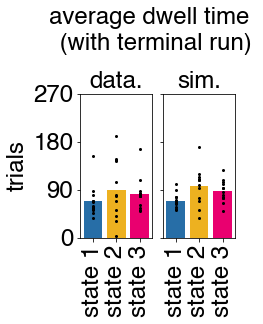

In [144]:
fig = plt.figure(figsize=(5,2))
# format axes (start left, start bottom, width, height)
axes = [plt.axes([0, 0, 0.20, 1]),plt.axes([.23, 0, .20, 1])]

plot_average_dwell_time(state_d1,sessions_d1,mouseIDs_d1,colors,axes[0],terminal_run=True)
plot_average_dwell_time(state_sim_d1[3],sessions_d1,mouseIDs_d1,colors,axes[1],terminal_run=True)
axes[0].set_title('data.',fontsize=24)
axes[0].set_yticks(np.arange(0,271,90))
axes[0].set_yticklabels(np.arange(0,271,90))
axes[1].set_title('sim.',fontsize=24)
axes[1].set_yticks(np.arange(0,271,90))
axes[1].set_yticklabels('')
axes[1].set_ylabel('')
plt.suptitle('average dwell time \n (with terminal run)',fontsize=24, x=0.2, y=1.6)